###Pydantic BaseModel and data validation

In [ ]:
import os
from pathlib import Path
from lib import cliBot
from IPython.core.display import Image
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START
from langgraph.prebuilt import ToolNode, tools_condition

from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

env_path = Path('../sample.env')
load_dotenv(override=True, dotenv_path=env_path)
model = os.getenv("GPT_MODEL")
print(model)

ModuleNotFoundError: No module named 'library'

In [2]:
memory = MemorySaver()
memory_config = {"configurable": {"thread_id": "1"}}


class DefaultState(MessagesState):
    summary: str
    pass

In [3]:
llm = ChatOpenAI(model=model)
tools_list = []
llm_with_tools = llm.bind_tools(tools_list)


def assistantBot(state: DefaultState) -> DefaultState:
    lastMsg = state['messages'][-1:]
    message = state['messages']

    summary = state.get('summary', '')
    if summary == '':
        system_message = f"Summary from previous conversation : {summary}"
        message = [SystemMessage(content = system_message)] + state['messages']
    else:
        pass
    #print(lastMsg, file=sys.stderr)
    return {"messages": [llm_with_tools.invoke(message)]}


In [4]:
#filter msg node basically help us to send last few msg only
from langchain_core.messages import  RemoveMessage
def filter_msg(state: DefaultState) -> DefaultState:
    delMsg = [RemoveMessage(id = m.id) for m in state['messages'][:-3]]
    return {"messages": delMsg}

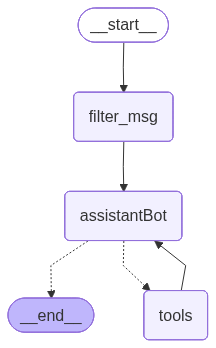

In [5]:
g = StateGraph(DefaultState)
g.add_node(filter_msg)
g.add_node(assistantBot)
g.add_node("tools", ToolNode(tools_list))

g.add_edge(START, "filter_msg")
g.add_edge("filter_msg", "assistantBot")
g.add_conditional_edges("assistantBot", tools_condition)
g.add_edge("tools", "assistantBot")

graph = g.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

Different input and output state example

    Input and output state can be differnt

In [6]:
import sys
try:
    cliBot(graphInstance=graph, config=memory_config, show_all_msg=False)
except KeyboardInterrupt as ki:
    print("User choose to exit", file=sys.stderr)
except Exception as e:
    print(e)

Question:
 Hi
Assistant:

Hello! How can I assist you today?


User choose to exit


In [7]:
graph.get_state(memory_config)

ValueError: No checkpointer set